In [1]:
import keras
keras.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


'2.1.5'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/fchollet/Downloads/cats_and_dogs_small'
base_dir = '/home/ubuntu/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 532us/step - loss: 0.5987 - acc: 0.6650 - val_loss: 0.4406 - val_acc: 0.8150
Epoch 2/30
2000/2000 [==============================] - 1s 339us/step - loss: 0.4326 - acc: 0.8010 - val_loss: 0.3658 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 336us/step - loss: 0.3619 - acc: 0.8400 - val_loss: 0.3283 - val_acc: 0.8680
Epoch 4/30
2000/2000 [==============================] - 1s 341us/step - loss: 0.3145 - acc: 0.8720 - val_loss: 0.3053 - val_acc: 0.8710
Epoch 5/30
2000/2000 [==============================] - 1s 343us/step - loss: 0.2874 - acc: 0.8805 - val_loss: 0.2853 - val_acc: 0.8820
Epoch 6/30
2000/2000 [==============================] - 1s 342us/step - loss: 0.2686 - acc: 0.8940 - val_loss: 0.2760 - val_acc: 0.8760
Epoch 7/30
2000/2000 [==============================] - 1s 341us/step - loss: 0.2569 - acc: 0.8960 - val_loss: 0.2817 - val_acc: 0.8800


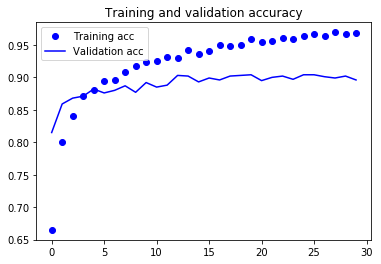

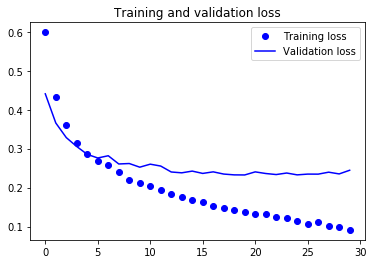

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [12]:
conv_base.trainable = False

In [13]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 28s - loss: 0.6032 - acc: 0.6775 - val_loss: 0.4503 - val_acc: 0.8310
Epoch 2/30
 - 26s - loss: 0.4679 - acc: 0.7930 - val_loss: 0.3672 - val_acc: 0.8610
Epoch 3/30
 - 26s - loss: 0.4340 - acc: 0.8090 - val_loss: 0.3331 - val_acc: 0.8730
Epoch 4/30
 - 26s - loss: 0.3996 - acc: 0.8275 - val_loss: 0.3033 - val_acc: 0.8880
Epoch 5/30
 - 26s - loss: 0.3871 - acc: 0.8320 - val_loss: 0.2890 - val_acc: 0.8900
Epoch 6/30
 - 26s - loss: 0.3677 - acc: 0.8425 - val_loss: 0.2819 - val_acc: 0.8800
Epoch 7/30
 - 26s - loss: 0.3566 - acc: 0.8405 - val_loss: 0.2880 - val_acc: 0.8830
Epoch 8/30
 - 26s - loss: 0.3532 - acc: 0.8445 - val_loss: 0.2692 - val_acc: 0.8990
Epoch 9/30
 - 26s - loss: 0.3491 - acc: 0.8410 - val_loss: 0.2580 - val_acc: 0.8960
Epoch 10/30
 - 26s - loss: 0.3431 - acc: 0.8370 - val_loss: 0.2595 - val_acc: 0.8920
Epoch 11/30
 - 26s - loss: 0.3364 - acc: 0.8480 - val_loss: 0.2541 - val_ac

In [15]:
model.save('cats_and_dogs_small_3.h5')

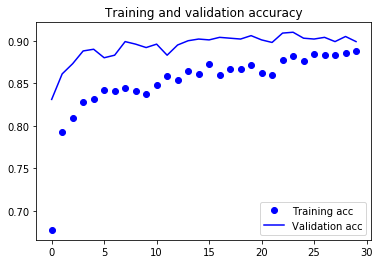

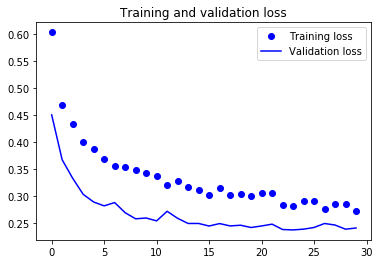

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 284ms/step - loss: 0.3127 - acc: 0.8680 - val_loss: 0.2321 - val_acc: 0.9090
Epoch 2/100
100/100 [==============================] - 26s 262ms/step - loss: 0.2721 - acc: 0.8865 - val_loss: 0.2054 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 27s 268ms/step - loss: 0.2493 - acc: 0.8950 - val_loss: 0.2022 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 26s 264ms/step - loss: 0.2222 - acc: 0.9105 - val_loss: 0.2694 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 27s 268ms/step - loss: 0.2032 - acc: 0.9165 - val_loss: 0.2102 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 27s 266ms/step - loss: 0.1922 - acc: 0.9220 - val_loss: 0.2056 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 26s 264ms/step - loss: 0.1852 - acc: 0.9195 - val_loss: 0.1897 - val_acc: 0.9240
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0295 - acc: 0.9895 - val_loss: 0.1922 - val_acc: 0.9460
Epoch 62/100
100/100 [==============================] - 26s 260ms/step - loss: 0.0214 - acc: 0.9915 - val_loss: 0.2756 - val_acc: 0.9260
Epoch 63/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0315 - acc: 0.9875 - val_loss: 0.2355 - val_acc: 0.9380
Epoch 64/100
100/100 [==============================] - 27s 273ms/step - loss: 0.0411 - acc: 0.9865 - val_loss: 0.1982 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 27s 269ms/step - loss: 0.0286 - acc: 0.9900 - val_loss: 0.2514 - val_acc: 0.9370
Epoch 66/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0317 - acc: 0.9885 - val_loss: 0.2238 - val_acc: 0.9360
Epoch 67/100
100/100 [==============================] - 27s 268ms/step - loss: 0.0211 - acc: 0.9905 - val_loss: 0.3024 - val_acc: 0.9300
Epoch 68/100
100/100 [===================

In [ ]:
model.save('cats_and_dogs_small_4.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)